# Vehicle Detection from Images
#Functions include: 
#1) detect vehicle from still pictures: rear facing and front facing 2) output the number of vehicles detected for the use case for realtime parking space detection.

In [1]:
import os, sys
import math
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image, PILLOW_VERSION

slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [4]:
isess = tf.InteractiveSession()

# Drawing and plotting routines.

In [5]:
def bboxes_draw_on_img(img, scores, bboxes, colors, thickness=2, show_text=True):
    """
    Drawing bounding boxes on an image, showing probability of the vehicle
    """
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        # randomly assign color for each bounding box to differentiate
        color = colors[i % len(colors)]
        # Draw bounding box on a image
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        if show_text:
            s = '%s: %s' % ('Car', scores[i])    
            p1 = (p1[0]-5, p1[1])
            cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
        
def plot_image(img, title='', figsize=(24, 9)):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    f.tight_layout()
    axes.imshow(img)
    axes.set_title(title, fontsize=20)

# Prepare SSD TensorFlow Network

Build up the deep convolutional network and load the checkpoint.

In [6]:
# imported and saved the pre-trained SSD VGG Network from Tensorflow
# under project folder /net
#pre-processing images to fit to sdd vgg 300 input requirements
from nets import ssd_vgg_300   # main ssd network from tensorflow
from nets import ssd_common    # 
from preprocessing import ssd_vgg_preprocessing
#from preprocessing import vgg_preprocessing_original  

# imported and saved the pre-trained SSD Network from Tensorflow respository 
# under checkpoints
# It contains: 
ckpt_filename = './checkpoints/ssd_model.ckpt'

In [7]:
# Insert a placeholder for a tensor that will be fed 
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(img_input, None, None, (None, None), resize=ssd_vgg_preprocessing.Resize.NONE)
#image_pre, labels_pre, bboxes_pre, bbox_img = vgg_preprocessing_original.preprocess_for_eval(
    #img_input, None, None, (None, None))

image_4d = tf.expand_dims(image_pre, 0)

# Network parameters.
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=8)

# SSD network construction
# SSDNet class is defined in ssd_vgg_300.py
# SSDNet defines parameters, network model, losses, anchor boxes
reuse = True if 'ssd' in locals() else None
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [8]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)

# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)
# Save back model to clean the checkpoint
save_clean = False
if save_clean:
    ckpt_filename_save = './checkpoints/ssd_model.ckpt'
    saver.save(isess, ckpt_filename_save, write_meta_graph=True, write_state=True)

INFO:tensorflow:Restoring parameters from ./checkpoints/ssd_model.ckpt


# Image Pipeline for SSD Network

Define the vehicle detection pipeline using SSD Network.

In [10]:
# define SSD processing function
# TensorFlow implementation pf boxes SSD encoding / decoding: ssd_common.py
# Encode groundtruth labels and bounding boxes using SSD net anchors.
""""
    Encoding boxes for all feature layers.

    Arguments:
      labels: 1D Tensor(int64) containing groundtruth labels;
      bboxes: Nx4 Tensor(float) with bboxes relative coordinates;
      anchors: List of Numpy array with layer anchors;
      matching_threshold: Threshold for positive match with groundtruth bboxes;
      prior_scaling: Scaling of encoded coordinates.

    Return:
      (target_labels, target_localizations, target_scores):
        Each element is a list of target Tensors.
"""
# Decode layer:
"""Compute the relative bounding boxes from the layer features and
    reference anchor bounding boxes.

    Arguments:
      feat_localizations: Tensor containing localization features.
      anchors: List of numpy array containing anchor boxes.

    Return:
      Tensor Nx4: ymin, xmin, ymax, xmax
"""
def ssd_process_image(img, select_threshold=0.6):
    """Process an image through SSD network.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold: Classification threshold (i.e. probability threshold for car detection).
    Return:
      rclasses, rscores, rbboxes: Classes, scores and bboxes of objects detected.
    """
    # Resize image to height 300.
    # the order of a picture's shape is a numpy array [height, width, depth]
    # use opencv is to scale and modify picture
    factor = 300. / float(img.shape[0])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    # utilize ssd_commom.py 
    """Extract classes, scores and bounding boxes from network output layers.

    Return:
      classes, scores, bboxes: Numpy arrays...
    """
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score
    """Sort bounding boxes by decreasing order and keep only the top_k
    """
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=True, margin=0.0)
    return rclasses, rscores, rbboxes

## Load sample image for SSD and Option 1 of NMS

Shape: (480, 640, 3)
Shape: (480, 640, 3)
Shape: (480, 640, 3)
Shape: (2448, 3264, 3)
Shape: (2448, 3264, 3)
Shape: (2448, 3264, 3)
Shape: (720, 1280, 3)
Shape: (720, 1280, 3)
Shape: (720, 1280, 3)
Shape: (720, 1280, 3)


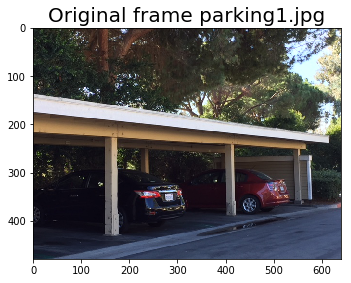

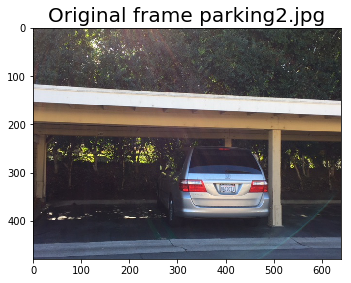

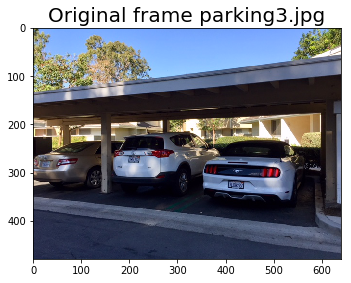

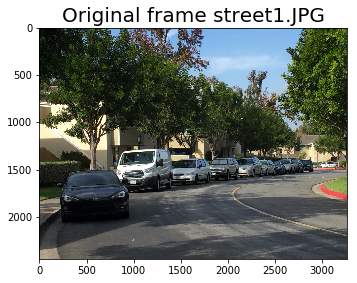

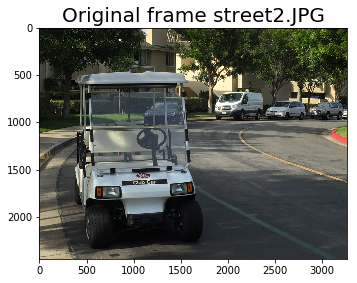

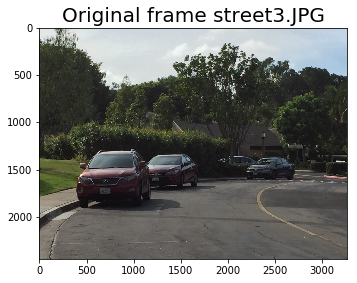

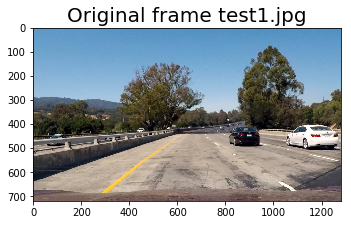

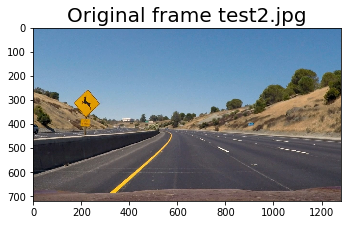

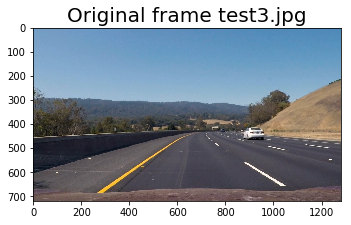

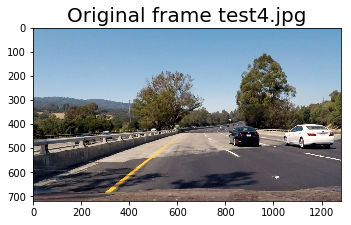

In [11]:
# Load a sample image.
path = 'test_images/'
image_names = sorted(os.listdir(path))
img = []
i = 1
while ((image_names) and (i<11)):
#for (f in image_names):
    img = mpimg.imread(path + image_names[i])
    print('Shape:', img.shape)
    # print(rbboxes)
    plot_image(img, 'Original frame '+ image_names[i], (5, 5))
    i += 1

## Option 1 Raw SSD output: multiple detections after simple thresholding

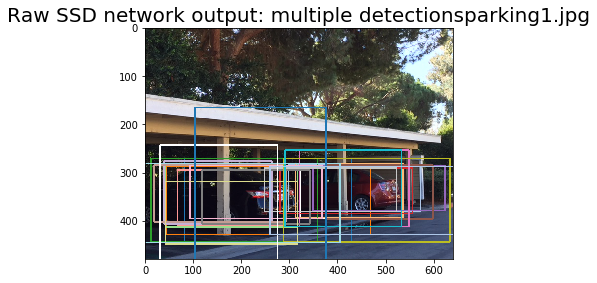

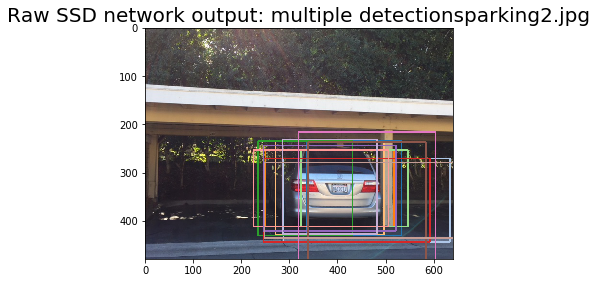

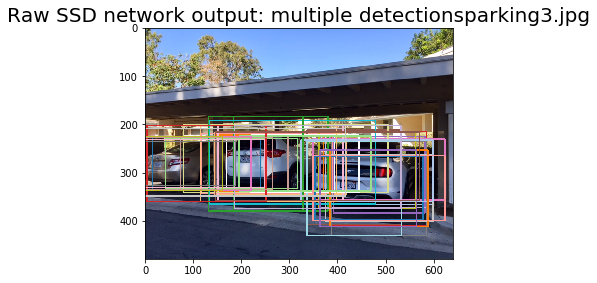

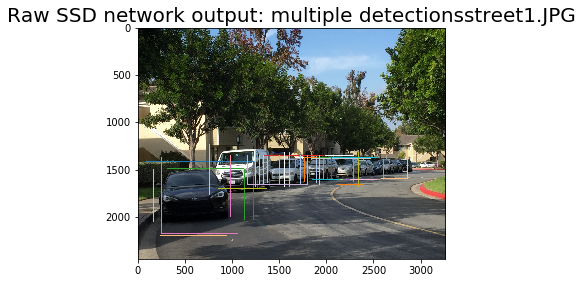

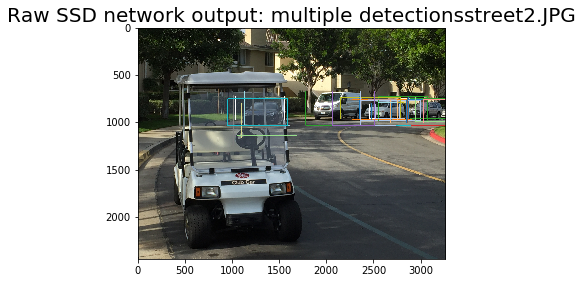

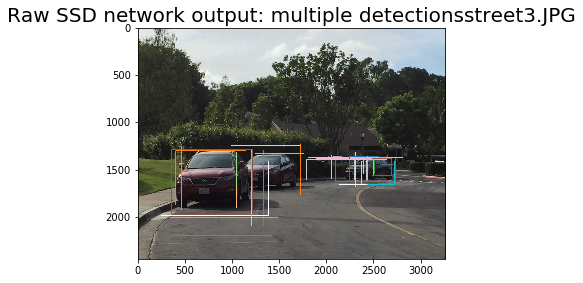

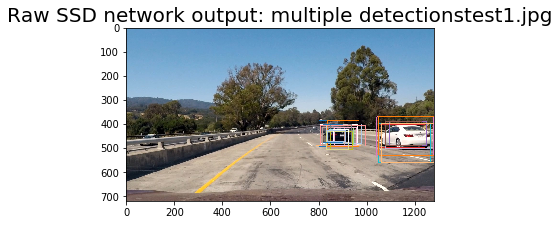

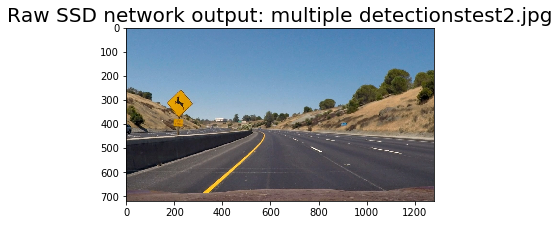

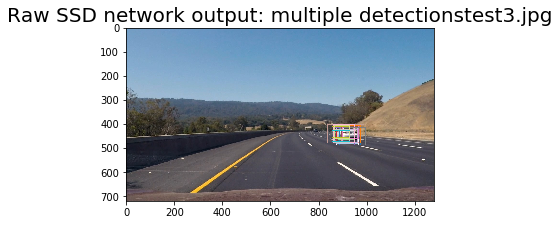

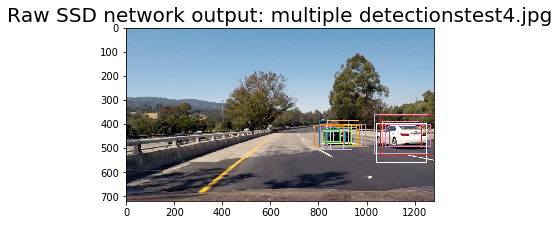

In [17]:
path = 'test_images/'
image_names = sorted(os.listdir(path))
i=1
#boundingboxes = []
while ((image_names) and (i<11)):
    # SSD network on image.
    img = mpimg.imread(path + image_names[i])
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
    #print (rbboxes)
    # Draw bboxes of detected objects.
    img_bboxes = np.copy(img)
    #plot_image(img_bboxes, 'what img_bboxes looks like now '+ image_names[i], (5, 5))
    bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
    #print(rbboxes)
    #box = rbboxes
    #boundingboxes.append(box)
    #print(boundingboxes)
    plot_image(img_bboxes, 'Raw SSD network output: multiple detections'+ image_names[i], (5, 5))
    i+=1

## Option 1 Apply Non-Maximum Supression Algorithm
made several experiments:
1) apply raw ssd with different thresholds: 
1.1 )result: accuracy is good for real facing vehicle detection e.g. driving picture and parking lot  
1.2 ) result is not very well for front facing vehicle detection: street parking
2) tune the paramters with Tensorflow ops python algorithm, result:

In [14]:
def bboxes_overlap(bbox, bboxes):
    """Computing overlap score between bboxes1 and bboxes2.
    Note: bboxes1 can be multi-dimensional.
    """
    if bboxes.ndim == 1:
        bboxes = np.expand_dims(bboxes, 0)
    # Intersection bbox and volume.
    int_ymin = np.maximum(bboxes[:, 0], bbox[0])
    int_xmin = np.maximum(bboxes[:, 1], bbox[1])
    int_ymax = np.minimum(bboxes[:, 2], bbox[2])
    int_xmax = np.minimum(bboxes[:, 3], bbox[3])

    int_h = np.maximum(int_ymax - int_ymin, 0.)
    int_w = np.maximum(int_xmax - int_xmin, 0.)
    int_vol = int_h * int_w
    # Union volume.
    vol1 = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    vol2 = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    score1 = int_vol / vol1
    score2 = int_vol / vol2
    return np.maximum(score1, score2)


def bboxes_nms_intersection_avg(classes, scores, bboxes, threshold=0.5):
    """Apply non-maximum selection to bounding boxes with score averaging.
    The NMS algorithm works as follows: go over the list of boxes, and for each, see if
    boxes with lower score overlap. If yes, averaging their scores and coordinates, and
    consider it as a valid detection.
    
    Arguments:
      classes, scores, bboxes: SSD network output.
      threshold: Overlapping threshold between two boxes.
    Return:
      classes, scores, bboxes: Classes, scores and bboxes of objects detected after applying NMS.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    new_bboxes = np.copy(bboxes)
    new_scores = np.copy(scores)
    new_elements = np.ones_like(scores)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            sub_bboxes = bboxes[(i+1):]
            sub_scores = scores[(i+1):]
            overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
            mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])
            while np.sum(mask):
                keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], ~mask)
                # Update boxes...
                tmp_scores = np.reshape(sub_scores[mask], (sub_scores[mask].size, 1))
                new_bboxes[i] = new_bboxes[i] * new_scores[i] + np.sum(sub_bboxes[mask] * tmp_scores, axis=0)
                new_scores[i] += np.sum(sub_scores[mask])
                new_bboxes[i] = new_bboxes[i] / new_scores[i]
                new_elements[i] += np.sum(mask)
                
                # New overlap with the remaining?
                overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
                mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])

    new_scores = new_scores / new_elements
    idxes = np.where(keep_bboxes)
    return classes[idxes], new_scores[idxes], new_bboxes[idxes]

number of car detected:  20


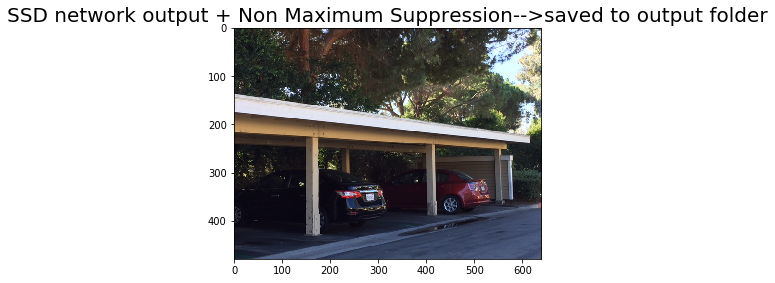

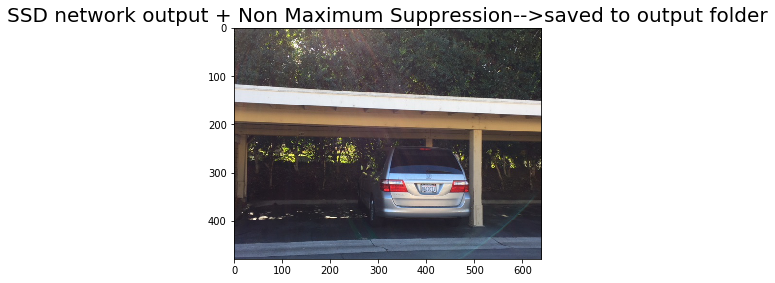

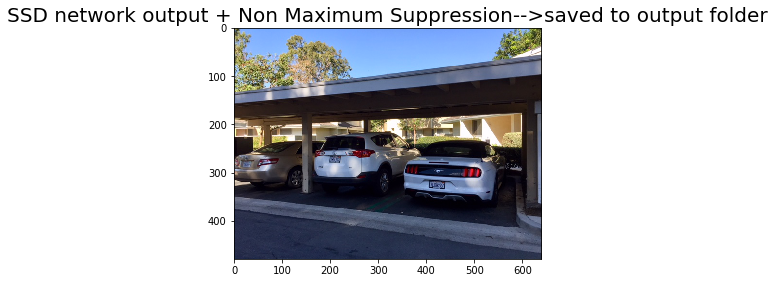

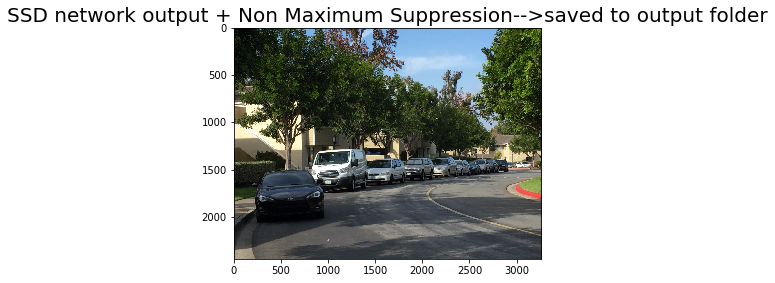

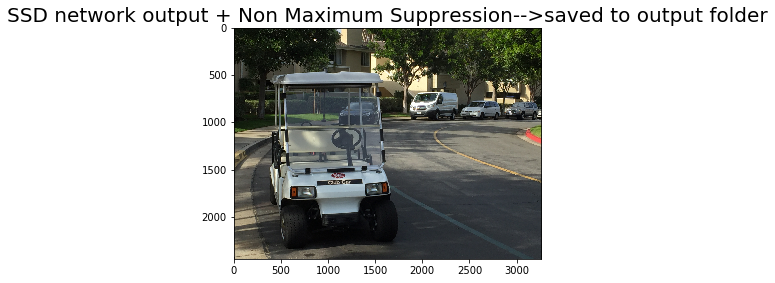

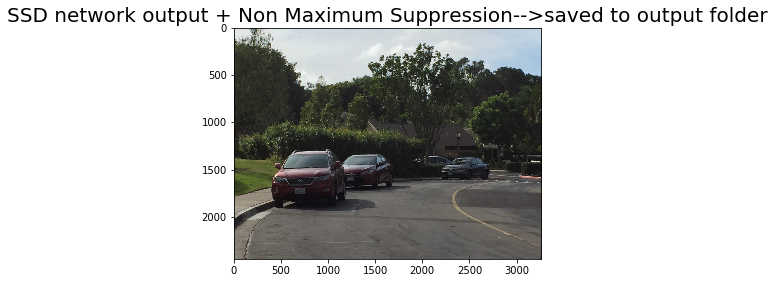

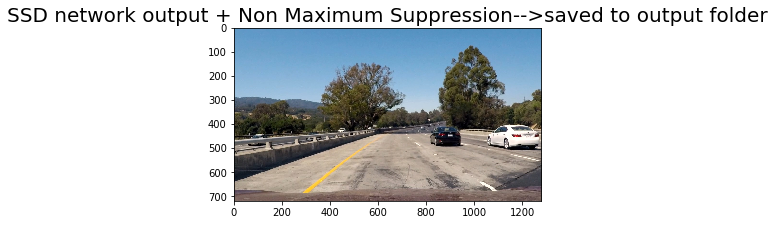

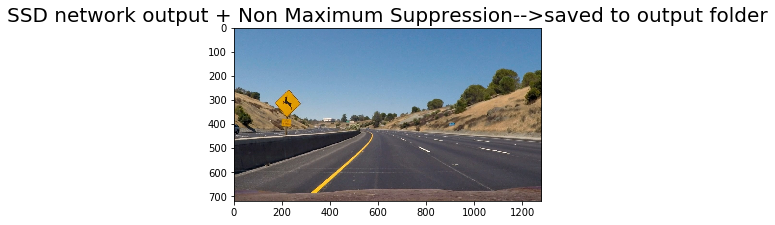

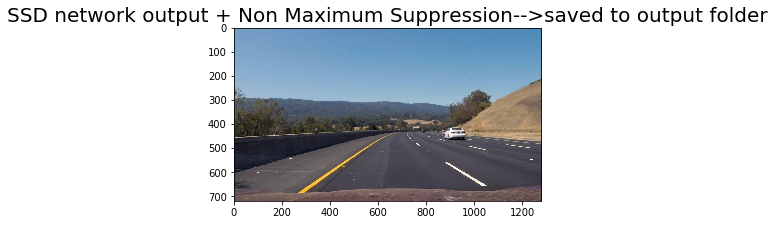

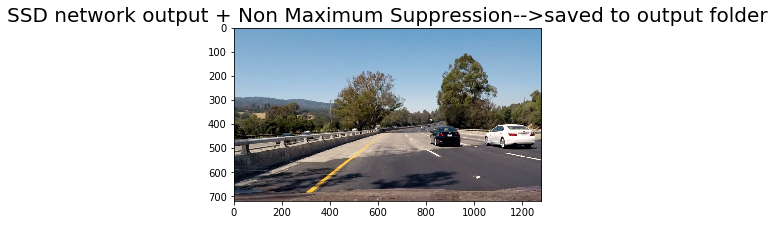

In [20]:
# function to compute bboxes overlap for all bboxes
# then apply nms algorithm to output one detection box
def nms_process_image(img, select_threshold=0.8, nms_threshold=0.5):
    # SSD network + NMS on image.
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold)
    rclasses, rscores, rbboxes = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Draw bboxes of detected objects.
    bboxes_draw_on_img(img, rscores, rbboxes, colors_tableau, thickness=2, show_text=True)
    return img

#NMS output:
path = 'test_images/'
image_names = sorted(os.listdir(path))
i=1
#initialize the number of car detected
num_car = 0
while ((image_names) and (i<11)):
    # SSD network on image.
    img = mpimg.imread(path + image_names[i])
    # re-process SSD Network since previous processing did not save to folder
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
    # Draw bboxes of detected objects.
    img_bboxes = np.copy(img)
    #bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
    #print(rbboxes)

    #plot_image(img_bboxes, 'Raw SSD network output: multiple detections'+ image_names[i], (5, 5))
    # Apply Non-Maximum-Selection
    #nms_threshold = 0.5
    #rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)

    #output image drawing to an output folder:
    outpath = 'output_images/'
    #img = mpimg.imread(path + image_names[i])
    #img_bboxes = np.copy(img)
    #bboxes_draw_on_img(img_bboxes, rscores_nms, rbboxes_nms, colors_tableau, thickness=2)
    
    img_out = nms_process_image(img, select_threshold=0.5, nms_threshold=0.8) #select_threshold from 0.8, nms_threshold from 0.5
    num_car= num_car + rbboxes_nms.shape[0]
    mpimg.imsave(outpath + image_names[i], img_out, format='jpg')
    plot_image(img_out, 'SSD network output + Non Maximum Suppression-->saved to output folder', (5, 5))

    i+=1
print("number of car detected: ",num_car)

# Load sample image for SSD and Option 2 of NMS

Shape: (2448, 3264, 3)


IndexError: list index out of range

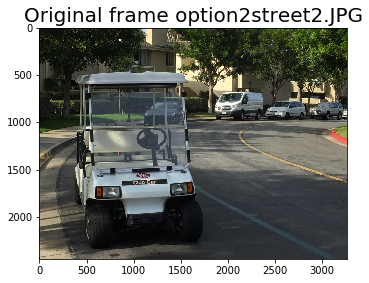

In [19]:
# Load a sample image.
path2 = 'option2_test_images/'
image_names = sorted(os.listdir(path2))
j = 1
while (j < 11):
#for (f in image_names):
    img = mpimg.imread(path2 + image_names[j])
    print('Shape:', img.shape)
    # print(rbboxes)
    plot_image(img, 'Original frame option2'+ image_names[j], (5, 5))
    j += 1

## Option 2 of Applying Raw SSD and Saved to output folder

IndexError: list index out of range

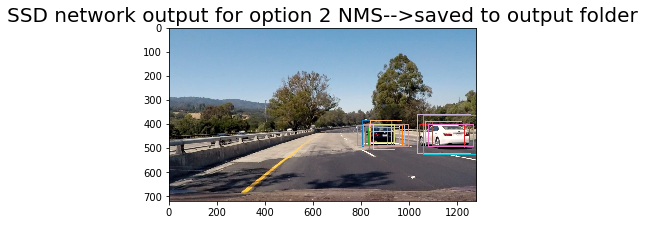

In [58]:
def process_image_option2(img, select_threshold=0.8):
    # SSD network + NMS on image.
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold)
    # Draw bboxes of detected objects.
    bboxes_draw_on_img(img, rscores, rbboxes, colors_tableau, thickness=2, show_text=True)
    return img

path = 'option2_test_images/'
image_names = sorted(os.listdir(path))
i=1
boundingboxes = []

while ((image_names) and (i<3)):
    # SSD network on image.
    img = mpimg.imread(path + image_names[i])
    
    #output image drawing to an output folder:
    outpath = 'option2_output_images/'
    img_out = process_image_option2(img, select_threshold=0.4) #select_threshold from 0.8
    box = rbboxes
    boundingboxes.append(box)
    #print(np.array(boundingboxes))
    mpimg.imsave(outpath + image_names[i], img_out, format='jpg')
    plot_image(img_bboxes, 'SSD network output for option 2 NMS-->saved to output folder', (5, 5))
    #plot_image(img_bboxes, 'Raw SSD network output: multiple detections'+ image_names[i], (5, 5))
    i+=1

## Option 2 of Try Another Non-Max Supression Algorithm

In [59]:
#  Felzenszwalb et al.
def non_max_suppression_slow(boxes, overlap_threshold):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in xrange(0, last):
            # grab the current index
            j = idxs[pos]
 
            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])
 
            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
 
            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
 
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)
 
        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)
 
    # return only the bounding boxes that were picked
    return boxes[pick]

In [60]:
# loop over the images that have applied SSD Network
imagePath = 'option2_output_images/'
image_names = sorted(os.listdir(path))
 
# construct a list containing the images that will be examined
# along with their respective bounding boxes
i = 1
while (i<3):
    images = (mpimg.imread(path + image_names[i]), np.array(boundingboxes))
    i += 1

# loop over the images
for (imagePath, boundingboxes) in images:
    # load the image and clone it
    print ("[x] %d initial bounding boxes" % (len(boundingboxes)))
    image = cv2.imread(imagePath)
    orig = image.copy()
 
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in boundingboxes:
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 0, 255), 2)
 
    # perform non-maximum suppression on the bounding boxes
    pick = non_max_suppression_slow(boundingBoxes, 0.3)
    print ("[x] after applying non-maximum, %d bounding boxes" % (len(pick)))
 
    # loop over the picked bounding boxes and draw them
    for (startX, startY, endX, endY) in pick:
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
 
    # display the images
    cv2.imshow("Original", orig)
    cv2.imshow("After NMS", image)
    cv2.waitKey(0)

IndexError: list index out of range